Please answer the questions below based on the data provided:

- Plot daily sales for all 50 weeks.
- It looks like there has been a sudden change in daily sales. What date did it occur?
- Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?
- Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).
- Assume a given day is divided into four dayparts: 
    - night (12:00AM - 6:00AM), 
    - morning (6:00AM - 12:00PM), 
    - afternoon (12:00PM - 6:00PM)
    - evening (6:00PM - 12:00AM).
    - What is the percentage of sales in each daypart over all 50 weeks?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os


# 1. Plot daily sales for all 50 weeks 

In [15]:
path = r"C:\Users\Wen\OneDrive\Documents\Machine Learning\Project\Sales_Data_Analysis\datasets"
file_pattern = os.path.join(path, "sales_week_starting_*.csv")

csv_files  = glob.glob(file_pattern)

data_frames = []

for file in csv_files:
    df = pd.read_csv(file)
    data_frames.append(df)
    
print(len(data_frames))

50


In [17]:
combined_df = pd.concat(data_frames) # combine all dataframes into a single 
print(combined_df)
print(combined_df.dtypes) # since the sale_time is object we need to convert to datatime

sale_day = pd.to_datetime(combined_df['sale_time'])
print(sale_day.dtypes)


                sale_time purchaser_gender
0     2012-10-01 01:42:22           female
1     2012-10-01 02:24:53           female
2     2012-10-01 02:25:40           female
3     2012-10-01 02:30:42           female
4     2012-10-01 02:51:32             male
...                   ...              ...
4994  2013-09-15 23:30:51           female
4995  2013-09-15 23:42:02           female
4996  2013-09-15 23:43:24             male
4997  2013-09-15 23:43:32             male
4998  2013-09-15 23:48:47             male

[204329 rows x 2 columns]
sale_time           object
purchaser_gender    object
dtype: object
datetime64[ns]
0   2012-10-01 01:42:22
1   2012-10-01 02:24:53
2   2012-10-01 02:25:40
3   2012-10-01 02:30:42
4   2012-10-01 02:51:32
Name: sale_time, dtype: datetime64[ns]


In [10]:
daily_sales = sale_day.groupby(sale_day.dt.floor('d')).size().reset_index(name='sales_amount') 
daily_sales.head()


,sale_time,sales_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476


We plot daily sales for all 50 weeks 

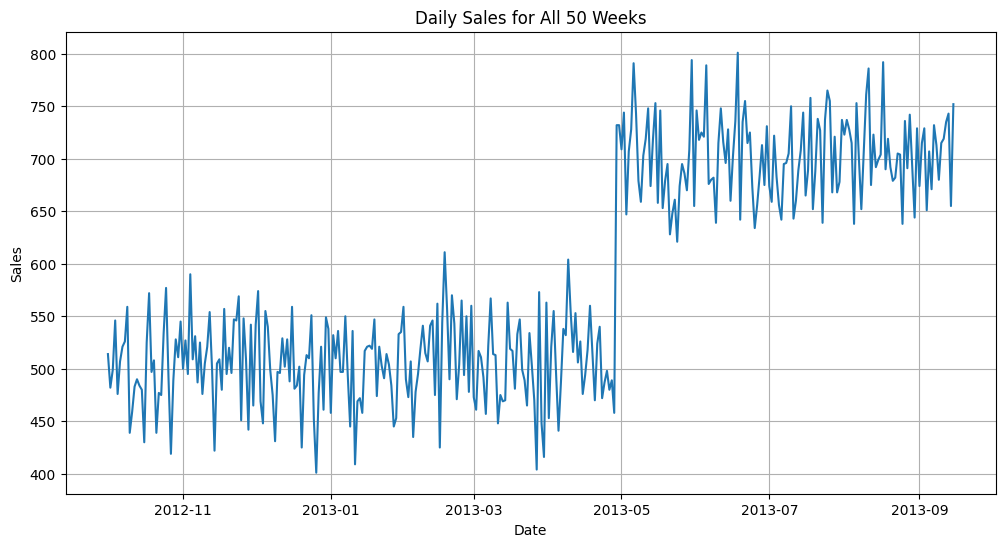

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['sale_time'], daily_sales['sales_amount'])
plt.title('Daily Sales for All 50 Weeks')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Question 2 

It looks like there has been a sudden change in daily sales. What date did it occur?


In [27]:
daily_sales['prev_day_sale_amount'] = daily_sales['sales_amount'].shift(1)
daily_sales['difference_between_prev_day'] = daily_sales['sales_amount'] - daily_sales['prev_day_sale_amount']

print(daily_sales.head())

   sale_time  sales_amount  sales_diff  prev_day_sale_amount  \
0 2012-10-01           514         NaN                   NaN   
1 2012-10-02           482        32.0                 514.0   
2 2012-10-03           499        17.0                 482.0   
3 2012-10-04           546        47.0                 499.0   
4 2012-10-05           476        70.0                 546.0   

   difference_between_prev_day  
0                          NaN  
1                        -32.0  
2                         17.0  
3                         47.0  
4                        -70.0  


In [34]:
max_difference_row = daily_sales.iloc[daily_sales['difference_between_prev_day'].abs().idxmax()]
print(f"The date with the biggest difference in daily sales is: {max_difference_row['sale_time']} with a difference of {max_difference_row['difference_between_prev_day']} sales.")


The date with the biggest difference in daily sales is: 2013-04-29 00:00:00 with a difference of 274.0 sales.
